## Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive


## Prepare data for time-series usage

In [0]:
import pandas as pd

df_train = pd.read_csv('orders0206_train.csv', sep='|', parse_dates=['time'])
df_test = pd.read_csv('orders0206_train.csv', sep='|', parse_dates=['time'])

df_info = pd.read_csv('infos.csv', sep='|', index_col='itemID')
product_prices = df_info['simulationPrice'].to_dict()
df_train["time"] = pd.to_datetime(df_train["time"], format='%Y-%m-%d %H:%M:%S')
df_train_small = df_train[df_train["itemID"].isin([7798])]

In [25]:
# aggregate sales per day
df_train_small['date'] = [d.date() for d in df_train_small['time']]
df_aggregated = df_train_small.groupby(['itemID','date']).sum()["order"].to_frame().reset_index().rename(columns={'order':'count'})
df_aggregated.head()

,itemID,date,count
0,7798,2018-01-01,17
1,7798,2018-01-02,36
2,7798,2018-01-03,24
3,7798,2018-01-04,41
4,7798,2018-01-05,32


In [26]:
# add 0 sales for missing dates per itemID
for prod in df_aggregated.itemID.unique():
    s = df_aggregated.loc[df_aggregated['itemID'] == prod][["date","count"]]
    s = s.set_index("date")
    idx = pd.date_range(s.index.min(), 
                        s.index.max())
    s.index = pd.DatetimeIndex(s.index)
    s = s.reindex(idx, fill_value=0)
    if "df_timeseries" not in globals():
        s["itemID"] = prod
        df_timeseries = s
    else:
        s["itemID"] = prod
        df_timeseries = pd.concat([df_timeseries,s], ignore_index=False)
df_timeseries.head(3)

,count,itemID
2018-01-01,17,NaN
2018-01-02,36,NaN
2018-01-03,24,NaN


In [0]:
import copy
# drop itemID as we don't need it for training
# 1 week period of testing
df_timeseries.drop(columns=['itemID'], inplace=True)
df = copy.deepcopy(df_timeseries[12:]) 
train, test = df[:-14], df[-14:]

## Install packages

In [8]:
import sys
!{sys.executable} -m pip install cufflinks

In [10]:
import sys
!{sys.executable} -m pip install pyramid.arima

     |████████████████████████████████| 604kB 2.7MB/s 


## Explore data

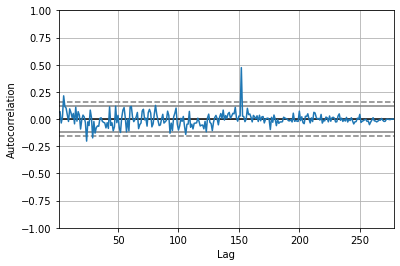

In [28]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train)
pyplot.show()
#nearly no siginificant auto-correlation, positive significant for 4? and 151? snd negative around 25

## Fit models
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [36]:
#model with own parameter settings:
#https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#p=4 because there the auto-correlation is significant, d=1 to make it stationary, m=7 daily (number of observations per seasonal cycle)
from pyramid.arima import auto_arima
stepwise_model = auto_arima(train, start_p=2, start_q=1,
                           max_p=6, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
model_fit_1 = stepwise_model.fit(train)
print(model_fit_1.summary())

Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=2207.931, BIC=2229.521, Fit time=2.273 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 7); AIC=2520.829, BIC=2528.026, Fit time=0.028 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 7); AIC=2383.813, BIC=2398.207, Fit time=0.451 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=2204.272, BIC=2218.666, Fit time=1.240 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 7); AIC=2211.035, BIC=2229.027, Fit time=1.362 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 7); AIC=2330.917, BIC=2341.712, Fit time=0.328 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 7); AIC=2210.522, BIC=2228.514, Fit time=1.164 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 7); AIC=2205.749, BIC=2227.340, Fit time=3.604 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 7); AIC=2205.912, BIC=2223.904, Fit time=2.101 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_o

In [30]:
#model with auto fit:
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model_fit = model.fit(train)
print(model_fit.summary())

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=2238.317, BIC=2260.083, Fit time=0.657 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=2236.040, BIC=2243.295, Fit time=0.015 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=2236.976, BIC=2247.859, Fit time=0.064 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=2237.106, BIC=2247.989, Fit time=0.099 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=2233.976, BIC=2248.486, Fit time=0.451 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=2239.521, BIC=2257.659, Fit time=0.331 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=2240.120, BIC=2258.258, Fit time=0.158 seconds
Total fit time: 1.783 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  278
Model:               SARIMAX(1, 0, 1)   Log Likelihood         

## Evaluate models
@Wei: Maybe you can write the function to output the predicted values (and compare them to the actual values in the test set), use forecast() or predict(), see here -> https://machinelearningmastery.com/make-sample-forecasts-arima-python/ in chapter Predict and Forecast or
here in chapter Rolling Forecast ARIMA Model: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/


In [0]:
#How many time periods? n_periods = The number of periods in the future to forecast.
future_forecast_1 = stepwise_model.predict(n_periods=14)
future_forecast_2 = model.predict(n_periods=14)

## Plot results

In [14]:
#this part is not working yet
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [15]:
#this part is not working yet
future_forecast = pd.DataFrame(future_forecast_1,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).iplot()